In [1]:
from __future__ import generators
import logging
import glob, os, functools
import sys

import SimpleITK as sitk
from scipy.signal import medfilt
import numpy as np
from numpy import median
import scipy
import nibabel as nib
import skimage
import matplotlib.pyplot as plt
import scipy.misc
from scipy import ndimage
from skimage.transform import resize,rescale
import cv2
import itk
import subprocess
from intensity_normalization.typing import Modality, TissueType
from intensity_normalization.normalize.zscore import ZScoreNormalize

import pandas as pd
import tensorflow as tf
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scripts.densenet_regression import DenseNet
from scripts.unet import get_unet_2D
from scripts.preprocess_utils import load_nii,enhance, save_nii, find_file_in_path,iou, enhance_noN4,crop_center, get_id_and_path
from scripts.feret import Calculater
from settings import  target_size_dense_net, target_size_unet, unet_classes, softmax_threshold, major_voting,scaling_factor
from scripts.infer_selection import get_slice_number_from_prediction, funcy
import warnings

warnings.filterwarnings('ignore')

os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'

physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
import math

def euclidean(x,y):
    #print(x,y)
    return math.sqrt((y[0] - x[0])**2 + (y[1] - x[1])**2)


def get_contour(img_input): 
    cnt,perimeter = 0,0
    max_cnt = 0
    binary = img_input>-1.7
    binary_smoothed = scipy.signal.medfilt(binary.astype(int), 51)
    img = binary_smoothed.astype('uint8')
    contours, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros(img.shape, np.uint8)
    #img = cv2.drawContours(mask, contours, -1, (255),1)
    for contour in contours:
        if cv.contourArea(contour)>cnt:
            cnt = cv.contourArea(contour)
            perimeter = cv.arcLength(contour,True)
            max_cnt = contour  
            convexHull = cv2.convexHull(contour)
    print(cnt,perimeter)
    img = cv2.drawContours(mask, [convexHull], -1, (255),1)
    
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    ax.imshow(img_input, interpolation=None, cmap=plt.cm.Greys_r)
    ax.imshow(img, cmap='jet',alpha=0.5)
    fig.show()
    
    p = 0
    for i in range(1,len(convexHull)):
        p = p + euclidean(convexHull[i][0],convexHull[i-1][0])
    print("Perim of the convex hull",p)
    
    return perimeter, p



2023-01-09 22:06:54.776002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-09 22:06:54.956101: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-09 22:06:55.014241: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-09 22:06:55.631822: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
input_annotation_file = 'data/pop_norms.csv'
df = pd.read_csv(input_annotation_file, header=0,)
df

,ID,Gender,Age,CSA PRED TM1,CSA PRED TM2,CSA PRED SUM,CSA PRED AVG,TM PRED1,TM PRED2,TMT PRED SUM,...,CSA PRED TM2 w line,CSA PRED SUM w line,CSA PRED AVG w line,TM PRED1 w line,TM PRED2 w line,TMT PRED SUM w line,TMT PRED AVG w line,INT AGE,GROUPS,Dataset
0,20170908-ST001-MNBCP270471_v01_1_4yr_MR-SE003-T1w,2,4,152,129,281,140.5,7.27,6.65,13.92,...,129,281,140.5,7.27,6.65,13.92,6.960,4,4,Baby
1,20170908-ST001-MNBCP270471_v01_1_4yr_MR-SE004-T1w,2,4,215,242,457,228.5,8.94,9.21,18.15,...,242,457,228.5,8.94,9.21,18.15,9.075,4,4,Baby
2,NCBCP269462-v01-1-48mo_8_T1w,1,4,51,159,210,105.0,4.02,7.59,11.61,...,159,210,105.0,4.02,7.59,11.61,5.805,4,4,Baby
3,NCBCP269462-v01-1-48mo_9_T1w,1,4,139,176,315,157.5,6.84,8.08,14.92,...,176,315,157.5,6.84,8.08,14.92,7.460,4,4,Baby
4,NCBCP838881-v01-1-48mo_12_T1w,1,4,185,269,454,227.0,7.33,10.62,17.95,...,269,454,227.0,7.33,10.62,17.95,8.975,4,4,Baby
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23689,sub-11643_ses-1_acq-1ADNIG2_T1w,2,18,565,547,1112,556.0,12.34,13.91,26.25,...,523,1054,527.0,12.29,13.72,26.01,13.005,18,18+,Petfrog
23690,sub-11644_ses-1_acq-1ADNIG2_T1w,1,14,616,578,1194,597.0,14.08,13.67,27.75,...,560,1087,543.5,12.57,13.51,26.08,13.040,14,14,Petfrog
23691,sub-11651_ses-1_acq-1ADNIG2_T1w,1,14,391,425,816,408.0,9.74,10.32,20.06,...,417,804,402.0,9.74,10.32,20.06,10.030,14,14,Petfrog
23692,sub-11660_ses-1_acq-1ADNIG2_T1w,2,14,669,649,1318,659.0,14.54,14.54,29.08,...,645,1298,649.0,14.51,14.26,28.77,14.385,14,14,Petfrog


In [3]:
model_weight_path_selection = 'model/densenet_models/test/brisk-pyramid.hdf5'

In [4]:
# load models
model_selection = DenseNet(img_dim=(256, 256, 1), 
                nb_layers_per_block=12, nb_dense_block=4, growth_rate=12, nb_initial_filters=16, 
                compression_rate=0.5, sigmoid_output_activation=True, 
                activation_type='relu', initializer='glorot_uniform', output_dimension=1, batch_norm=True )
model_selection.load_weights(model_weight_path_selection)
print('\n','\n','\n','loaded:' ,model_weight_path_selection)  

2023-01-09 22:06:57.954682: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-09 22:06:59.814990: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46196 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:31:00.0, compute capability: 8.6



 
 
 loaded: model/densenet_models/test/brisk-pyramid.hdf5


data/t1_mris/registered/z/NCBCP269462-v01-1-48mo_9_T1w/NCBCP269462-v01-1-48mo_9_T1w.nii
6/6 [==============================] - 0s 26ms/step
65
18162.0 509.7300080060959
Perim of the convex hull 474.9837656955419


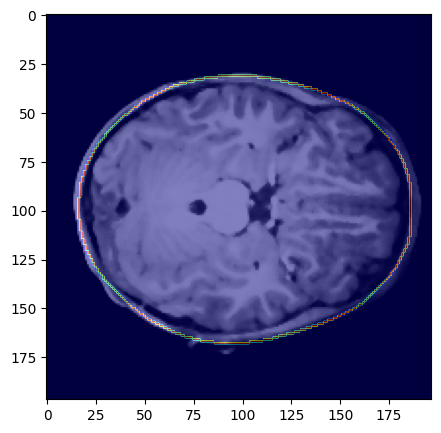

In [226]:
mri_source_path = 'data/t1_mris/registered/z/'
i = 3
for image_path in os.listdir(mri_source_path):
    if df['ID'].iloc[i] in image_path:
        image_path = mri_source_path+df['ID'].iloc[i]+"/"+os.listdir(mri_source_path+df['ID'].iloc[i])[0]
        print(image_path)
        image_sitk = sitk.ReadImage(image_path)    
        windowed_images  = sitk.GetArrayFromImage(image_sitk)   
    
        # enchancing is done in the preprocessing step
        resize_func = functools.partial(resize, output_shape=model_selection.input_shape[1:3],
                                            preserve_range=True, anti_aliasing=True, mode='constant')
        series = np.dstack([resize_func(im) for im in windowed_images])
        series = np.transpose(series[:, :, :, np.newaxis], [2, 0, 1, 3])

        series_n = []

        for slice_idx in range(2,np.shape(series)[0]-2):
            im_array = np.zeros((256,256,1,5))
                
            im_array[:,:,:,0] = series[slice_idx-2,:,:,:].astype(np.float32)
            im_array[:,:,:,1] = series[slice_idx-1,:,:,:].astype(np.float32)
            im_array[:,:,:,2] = series[slice_idx,:,:,:].astype(np.float32)
            im_array[:,:,:,3] = series[slice_idx+1,:,:,:].astype(np.float32)
            im_array[:,:,:,4] = series[slice_idx+2,:,:,:].astype(np.float32)
                
            im_array = np.max(im_array, axis=3)
                
            series_n.append(im_array)
            series_w = np.dstack([funcy(im) for im in series_n])
            series_w = np.transpose(series_w[:, :, :, np.newaxis], [2, 0, 1, 3])

        predictions = model_selection.predict(series_w)
        slice_label = get_slice_number_from_prediction(predictions)
        print("slice_label",slice_label)
        img = nib.load(image_path)  
        image_array, affine = img.get_fdata(), img.affine
        image_array_2d = image_array[:,15:-21,slice_label] 
        perimeter_opencv,perimeter_convex = get_contour(image_array_2d)